# Tutorial: Sensitivity Analysis of the HYMOD Model

The purpose of this tutorial is to demonstrate the global sensitivity analysis concepts and tools established in the Section 3.1 of the main text of this eBook. This demonstration will highlight the central role of design of experiments (Section 3.3), when implementing global sensitivity analysis tools described in Section 3.4.

We'll explore these tools and concepts using the HYdrological MODel (HYMOD), a rainfall-runoff model developed and used for river flow forecasting. HYMOD was chosen for demonstration because its purpose is to abstract highly complex and non-linear systems. The methods demonstrated in thistutorial can be applied to numerical models that simulate other complex non-linear systems.

This tutorial will first introduce HYMOD and use it to simulate streamflows in a river basin. Next, we'll employ sensitivity analysis concepets described in Section 3 of the main text to examine how values of HYMOD's parameters impact streamflow predictions. We'll then explore how the effects of these parameters may change over time using time-varying sensitivtiy analysis. Finally, we'll demonstrate concepts presented in Chapter 7 through two ensemble-based methods of uncertainty quantification - Generalized Likelihood Uncertainty Estimation (GLUE) and Pre-Calibration. 

The tutorial includes the following steps:

#### 1. Introduction to HYMOD
[1.1 - Introduction to a simple hydrologic model (HYMOD)](#hymod) <br>
[1.2 - Input Data](#inputs) <br>
[1.3 - Running a basic simulation](#baseline) <br>
[1.4 - Model outputs](#outputs) <br>

#### 2. Global Sensitivity Analysis
[2.1 - Design of Experiments](#sensitivity)  <br>
[2.2 - Sensitivity analysis for one output](#sa_metrics)  <br>
[2.3 - Sensitivity analysis across multiple outputs](#diff_performance) <br>
[2.4 - Time-varying sensitivity analysis](#TVSA)  <br>

# 1 - Introduction to HYMOD

<a id='hymod'></a> 
# 1.1- Overview

HYMOD is a hydrologic model (rainfall-runoff model) that simulates key hydrologic fluxes such as infiltration, streamflow and evapotranspiration. The model was originally developed and used for river flow forecasting, but it has also been been used to explore different sensitivity analysis (e.g., [Herman et al., 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/wrcr.20124)), uncertainty quantification (e.g.,  [Smith et al., 2008](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006WR005205)), and optimization (e.g., [Ye et al., 2014](https://www.sciencedirect.com/science/article/pii/S0022169414006362?casa_token=IRqE19Hkfa8AAAAA:_fXOqfwpzxMpchvu8_0njCe0Ok9H29Gyw2F46l9PzG9UVODDTUg6wIOSiyp6uybGevNVnZ7N)) concepts.

HYMOD accepts two inputs - daily precepitation and daily potential evapotranspiration (PET)- and generates predicitons of daily streamflow. HYMOD abstracts the highly non-linear process of runoff routing by dividing the flow into two components: quick flow, representing precipitation that quickly runs off the surface of the watershed into the stream, and slow flow, that moves through the soil and takes much longer to arrive at the stream.

To generate streamflow predictions, HYMOD first models vertical processes within the watershed to determine how much water infiltrates and evaporates from the soil at a given time step. It then determines how much water should be partitioned into quick flow and slow flow processes. Within each process it abstracts residence time (the time it takes a unit volume of water to move through the watershed and into the stream) using a series of "reservoirs" each with a calibrated residence time. 

HYMOD's representation of hydrologic processes are shown Figure 1 below and controlled by the following parameters:

$H_{uz}$: the maximum water storage capacity of the soil (mm)

$B_{exp}$: parameters describing the degree of spatial variability within the basin between 0 and Huz

$Alp$:    Fraction of runoff contributing to quick flow 

$K_q$:     Quick flow residence time of linear infinite reservoir (the Kq values of all three linear reservoirs are the same)

$K_s$:      Slow flow residence time of linear infinite reservoir


![alt text](./figs/hymod_schematic-DAVE.png "Title")

### Vertical Processes

HYMOD models the fraction of water that is stored in the soil $(F(XH_{uz}))$ using the following relationship:

$$F(XH_{uz}) = 1 - (1 - \frac{XH_{uz}}{H_{uz}})^{B}$$

where *$XH_{uz}$* is the water storage capacity of the soil; **$H_{uz}$** is the parameter describing basin maximum water storage capacity (mm); and **$B$** is the parameter describing the degree of spatial variability within the basin. 

The portion of precipitation that exceeds the water storage capacity is treated as runoff.

### Horizontal Processes
To route runoff to streamflow, the excess runoff from the vertical processes is split into quick flow and slow flow. The proportion of runoff partitioned into quick flow and slow flow is determined by a parameter $Alp$, which ranges between 0 and 1. Quick flow is routed through $N$ identical quick flow tanks $Q1, Q2... QN$ (shown above as $N=3$). The rate at which runoff moves through the quick flow system is described by the residence time of the quick frlow tanks, $Kq$ (day). Slow flow is routed through a parallel slow flow tank and the rate at which slow flow is routed is described by the slow flow residences time, $Ks$ (day).  

Citation: Wagener, T., Boyle, D. P., Lees, M. J., Wheater, H. S., Gupta, H. V., & Sorooshian, S. (2001). A framework for development and application of hydrological models. Hydrology and Earth System Sciences, 5(1), 13-26.

<a id='inputs'></a> 
### 1.2 Input data

The HYMOD model only requires precipitation and potential evapotranspiration as inputs. For this example, we'll run HYMOD using data from the Leaf River, a humid catchment located north of Collins Mississippi that has been widely used to explore HYMOD. The dataset also includes daily observed runoff that we later use to evaluate the performace of each sensitvity analysis sample set. 

In the following section of code, we'll load the necessary python libraries and read in the input file. For this exercise we'll only use the first eleven years of data. The first five rows of the input dataset are printed to show what they look like:

In [1]:
import msdbook

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from matplotlib import pyplot as plt

# load example data
msdbook.install_package_data()

# load the Leaf River HYMOD input file
leaf_data = msdbook.load_hymod_input_file()

# extract the first eleven years of data
leaf_data = leaf_data.iloc[0:4015].copy()

print('Leaf River Data structure:')

# There are only three columns in the file including precipitation, potential evapotranspiration and  streamflow
leaf_data.head()

Leaf River Data structure:


,Precip,Pot_ET,Strmflw
0,0.0,4.60,0.29
1,0.0,4.31,0.24
2,0.0,4.33,0.21
3,0.0,4.78,0.19
4,0.0,2.91,0.18


To visualize catchment hydrology, streamflow and precipitation data are usually plotted together as a combined hydrograph (streamflow ) and hyetograph (rainfall, from Greek.hyetos, “rain”). Streamflow is plotted as a time series, while rainfall is shown as an inverted bar plot along the top of the graph. Streamflow labels are shown on the left y-axis, while rainfall labels are shown on the right y-axis.

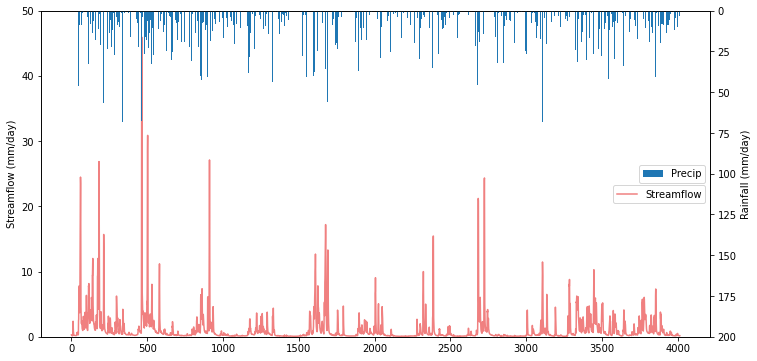

In [2]:
# make an axis for the hydrograph
fig, strmflw_ax = plt.subplots(figsize=[12,6])
strmflw_ax.set_ylim([0, 50])

#make a second y-axis for the hyetograph
precip_ax = strmflw_ax.twinx()
precip_ax.set_ylim([0, 200])
precip_ax.invert_yaxis()

precip = leaf_data['Precip']
strmflw_ax.plot(range(0, len(leaf_data['Precip'])), leaf_data['Strmflw'], color='lightcoral')
strmflw_ax.set_ylabel('Streamflow (mm/day)')

precip_ax.bar(range(0, len(leaf_data['Precip'])), leaf_data['Precip'], width=2)
precip_ax.set_ylabel('Rainfall (mm/day)')
precip_ax.legend(['Precip'], loc='center right')
strmflw_ax.legend(['Streamflow'],bbox_to_anchor=(1, 0.48))


<a id='baseline'></a> 
### 1.3 Running a Baseline Model Simulation

We'll start our experiment by running HYMOD using its default parameters.


In [3]:
# assign input parameters to generate a baseline simulated streamflow
Nq = 3  # Number of quickflow routing tanks 
Kq = 0.5 # Quickflow routing tanks' rate parameter    
Ks =  0.001 # Slowflow routing tank's rate parameter           
Alp = 0.5 # Quick/slow split parameter   
Huz = 100 # Maximum height of soil moisture accounting tank  
B = 1.0 # Scaled distribution function shape parameter    

# Note that the number of years is 11. One year of model warm-up and ten years are used for actual simulation
model = msdbook.hymod(Nq, Kq, Ks, Alp, Huz, B, leaf_data, ndays=4015)


<a id='outputs'></a> 
### 1.4 Model Outputs

Model outputs include actual evapotranspiration, quick and fast streamflow, and combined runoff. In this tutorial we focus on the total daily runoff, QQ ($m^3/s$). We can use the following script to plot simulated streamflow against observed streamflow.

<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/docs/html/A3_plotting_code.html#plot-observed-vs-simulated-streamflow">plot_observed_vs_simulated_streamflow</a>

</div>

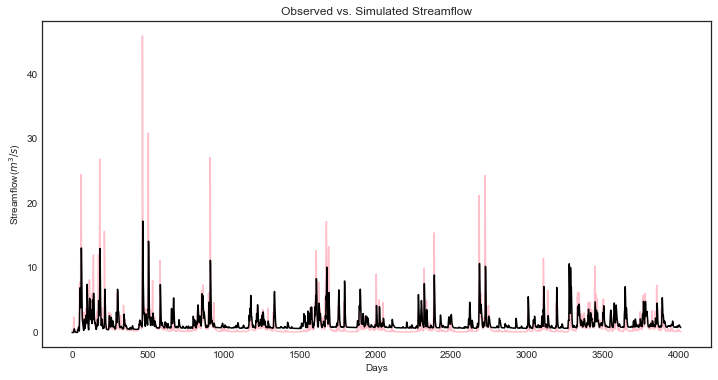

In [4]:
ax = msdbook.plot_observed_vs_simulated_streamflow(df=leaf_data, hymod_dict=model)

So how does our model perform? We can investigate model performance across several metrics:

1: Mean Absolute Error (MAE);
MAE conveys how the model performs on average across the 10 year simulation period, with smaller values indicating better performance. The absolute value is taken so that positive and negative errors do not cancel each other out.

$$MAE = \frac{1}{N}\sum_{t=0}^N\left\lvert Q_{sim,t}-Q_{obs,t}\right\rvert$$

2: Root Mean Square Error (RMSE);
RMSE is sum of square errors across the 10 year simulation period. RMSE is sensitive to large errors between the historical record and the simulated flows, and thus is useful for highlighting the model's ability to capture of extreme flood events.

$$RMSE = \sqrt{\frac{1}{N}\sum_{t=1}^{N}(Q_{sim,t}-Q_{obs,t})^2}$$

3: Log-Root Mean Square Error (Log(RMSE))
LOG(RMSE) focuses on model performance during low-flow events.

$$LOG(RMSE) = log(RMSE)$$


In [7]:
mae = np.mean(abs(leaf_data['Strmflw'] - model['Q']))
mse = metrics.mean_squared_error(model['Q'], leaf_data['Strmflw'])
rmse = mse**(1/2)

print('MAE: ' + str(mae) + '\nRMSE: ' + str(mse) + '\nLOG(RMSE): ' + str(rmse))

MAE: 1.0787471470461014
RMSE: 4.375695937555197
LOG(RMSE): 2.0918164206151544


The error metrics show that HYMOD performs reasonably well, the MAE is around 1 $m^3/s$, the RMSE is on the order of 10% of the largest observed streamflow and the LOG(RMSE) is fairly low.

# 2- Global Sensitivity Analysis

<a id='sensitivity'></a> 
## 2.1- Experimental Design and Setup

Now we'll examine how sensitive streamflow simulations generated by HYMOD are to the model's input parameters. We'll perform global sensitivity analysis (see Section 3.1 of the main text) using the SALib Python library.

In [8]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.analyze import delta

A first and critical step when conducting sensitivity analysis is determining the experimental design (see Design of Experiments, Section 3.4 of the main text). Our experimental design involves defining the uncertainties that we'll be examining, the output of interest, the ranges of each uncertainty that will be explored and the strategy for sampling the uncertainty space.

For this experiment we'll explore the five parameters highlighted in Figure 1. We'll draw their ranges from existing literature on the model (note Jon H. paper). We'll use a Sobol sampling an  a quasi-random sampling with low sequences approach to sample the uncertainty space (Section 3.3.4).

In this demonstration we'll utilize Sobol Sensitivity Analysis, a variance based method (Section 3.4.5). 

To explore HYMOD's behavoir, we'll examine the sensitivity of four model ouputs to input parameters: 1) predicted flow, 2) Mean Absolute Error (compared with the calibaration data set), 3) Root Mean Square Error and 4) Log Root Mean Square Error.

This analysis will employ SALib, a Python implementation also utilized in the other SA tutorial (make this more formal).

To start our analysis, we'll create a dictionary that describes our model uncertainties and their ranges, this dictionary is named "problem_hymod" (SALib refers to these dictionaries as "problems"). 

In [9]:
problem_hymod = {
    'num_vars': 5,
    'names': ['Kq', 'Ks', 'Alp', 'Huz', 'B'],
    'bounds': [[0.1, 1],  # Kq
               [0, 0.1],  # Ks
               [0, 1],    # Alp
               [0.1, 500],  # Huz
               [0, 1.9]]  # B             
}

After defining our uncertainites and ranges, we'll use SALib to sample the uncertainty space and run the model for each of the sample sets. We will load a sample that has already been created `param_values_hymod` for demonstration purposes. For HYMOD, literature recommends running at least N = 10,000 samples, to keep this demonstration easy to run however, we utilize only 256 sobol samples of uncertainties. To generate accurate approximations of second order sensitivity indicies SALib generates N*(2k+2) sets of samples, where N=256 and k=5 (number of uncertainties). For the math behind why this is needed, see (Saltelli, A., 2002. Making best use of model evaluations to compute sensitivity indices. Computer Physics Communications 145, 280–297. https://doi.org/10.1016/S0010-4655(02)00280-1).


The actual model simulation takes an extended period, so we also load the simulation data from a previous run. The following demonstrates how to conduct this analysis:
```python

# generate 256 samples.
param_values_hymod = saltelli.sample(problem_hymod, 256)

# dictionary to store outputs in
d_outputs = {}

# run simulation for each parameter sample
for i in range(0, len(param_values_hymod)):
    
    # run model for each sensitivity analysis parameter sets
    hymod_output = msdbook.hymod(Nq, 
                                 param_values_hymod[i, 0], 
                                 param_values_hymod[i, 1], 
                                 param_values_hymod[i, 2], 
                                 param_values_hymod[i, 3], 
                                 param_values_hymod[i, 4], 
                                 leaf_data, 
                                 ndays=4015)
    
    # store the simulated total flow discharge
    d_outputs[f"Q{i}"] = hymod_output["Q"]

    
Q_df_bw = pd.DataFrame(d_outputs)
```



In [10]:
# load previously generated parameter values 
param_values_hymod = msdbook.load_hymod_params()

# number of samples
n_samples = len(param_values_hymod)

# load previously generated hymod simulated outputs
Q_df_bw = msdbook.load_hymod_simulation()

# column names of each sample simulation number
sample_column_names = [i for i in Q_df_bw.columns if i[0] == 'Q']


#### Running HYMOD - Model Warm-up
A hydrological model such as HYMOD usually includes ordinary differential equations that are sensitive to their initial condition. They also have components in their underlying formulation that have long memory such that prior time steps can affect their current simulations. For example, soil moisture or groundwater can hold water for a long time and therefore they are often considered to exhibit a long memory. This can affect the partitioning of water to runoff and infiltration, while also controlling the generation of base flow. Therefore, it is important to have a reasonable initial value for them. To achieve this, hydrologists usually extend their simulation period and after the simulations, they remove that extended time period that has unreasonable groundwater or surface water values. This time period is called the warm-up time period.

Here we extended our simulation for one year (from 10 years to 11 years) and we removed the first year of simulation, therefore our warm-up period is one year.

In [11]:
# exclude the first year of simulation from the simulations and reset the index
Q_df = Q_df_bw.iloc[365:4015].copy().reset_index(drop=True)

# exclude the first year of the input data and reset the index
leaf_data = leaf_data.iloc[365:4015].copy().reset_index(drop=True)


Now that HYMOD has been warmed up, we'll examine how HYMOD's streamflow outputs vary under different sample sets, and compare them with the observed streamflow.

In [12]:
# add date columns to our simulation data frame; for this data our start date is 1/1/2000
date_ts = pd.date_range(start='1/1/2000', periods=3650, freq='D')
Q_df['date'] = date_ts
Q_df['year'] = date_ts.year
Q_df['month'] = date_ts.month
Q_df['day'] = date_ts.day

# aggregate the simulated observed streamflow to monthly mean
df_sim_mth_mean = Q_df.groupby(['year', 'month'])[sample_column_names].mean()

# do the same for the observed data
date_ts = pd.date_range(start='1/1/2000', periods=len(leaf_data), freq='D')
leaf_data['date'] = date_ts
leaf_data['year'] = date_ts.year
leaf_data['month'] = date_ts.month
leaf_data['day'] = date_ts.day

# aggregate the daily observed streamflow to monthly mean
df_obs_mth_mean = leaf_data.groupby(['year', 'month']).mean()


<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/docs/html/msd_uncertainty_ebook/A3_plotting_code.html#plot-observed-vs-sensitivity-streamflow">plot_observed_vs_sensitivity_streamflow</a>
</div>

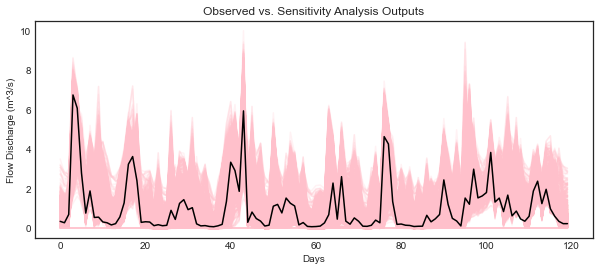

In [13]:
ax = msdbook.plot_observed_vs_sensitivity_streamflow(df_obs=df_obs_mth_mean, 
                                                     df_sim=df_sim_mth_mean)


<a id='sa_metrics'></a> 
### 2.2 - Sensitivity of streamflows to model parameters

Now we'll examine how each of HYMOD's parameters impact the variance of simulated streamflows. Using SALib we'll calculate the first order and total order sensitivity indicies of each model parameter. The first order sensitivity index measure's the individual impact that a given parameter has on the variance of the simulated streamflows. The total order index measures the impact of a given parameter along with all interactions that other parameters have with the given parameter on simulated streamflows.

We'll start with an matrix, Y, which contains our simulated streamflows for every uncertainty sample. We'll then use the sobol.analyze function from SALib to calculate the sensitivity indicies (Si). The arguments for this function are the problem dictionary defined in part 2.2 of this tutorial, and the matrix of simulated streamflows, Y.

In [14]:
# overall aggregated indices
Y = Q_df[sample_column_names].mean().to_numpy()

# Perform analysis
Si = sobol.analyze(problem_hymod, Y)

Now we can examine our results, we'll print the first order and total order Si's for each parameter, then visualize the results with bar plots

First order indices =  [9.55550001e-05 7.49249463e-04 5.62386413e-04 7.03327551e-01
 2.53701895e-01]
Total order indicies =  [1.76174200e-06 1.63288175e-03 3.41378460e-04 6.88983864e-01
 2.53922146e-01]


C:\Users\dgold\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\dgold\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


(0.0, 1.0)

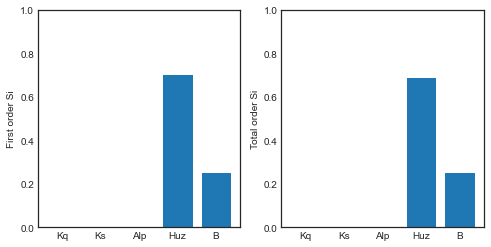

In [25]:
print('First order indices = ', Si['S1'])

print('Total order indicies = ', Si['ST'])

sns.set_style('white')
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.bar(np.arange(5), Si['S1'])
ax1.set_xticklabels(['','Kq', 'Ks', 'Alp', 'Huz', 'B'])
ax1.set_ylabel('First order Si')
ax1.set_ylim([0,1])

ax2 = fig.add_subplot(122)
ax2.bar(np.arange(5), Si['ST'])
ax2.set_xticklabels(['','Kq', 'Ks', 'Alp', 'Huz', 'B'])
ax2.set_ylabel('Total order Si')
ax2.set_ylim([0,1])


Our findings indicate that in this instance, the streamflow estimate from HYMOD is highly sensitive to soil moisture parameters Huz and B and hardly affected by the routing parameters. Notably, there is very little interactions between parameters causing the total order indicies to be nearly identical to the first order indicies.

<a id='diff_performance'></a> 
## 2.3 How do different performance metrics affect the results of our sensitivity analysis?

Streamflow has many different properties. In this section, we discuss how the selection of metrics can lead to fundamentally different sensitivity analysis results. For example, one can only focus on aggregated streamflow metrics such as mean (what has been presented so far), or only on extreme events such as drought or floods.

Here we compare three different metrics:
1- Mean error (ME) 2- Root Mean Square Error (RMSE) 3- Log-Root Mean Square Error (Log(RMSE))

Each of these metrics focuses on a specific attribute of streamflow. For example, RMSE highlights the impacts of extreme flood events, while LOG(RMSE) focuses on model performance during low-flow events.

In [32]:
# calculate error metrics
mae = Q_df[sample_column_names].apply(lambda x: abs(x-leaf_data["Strmflw"]), axis=0)
mse = Q_df[sample_column_names].apply(lambda x: metrics.mean_squared_error(x, leaf_data["Strmflw"]), axis=0)
rmse = mse**(1/2)

# add error metrics to a dictionary
d_metrics = {'MAE': mae.mean().values,
             'RMSE': rmse.values,
             'LOG[RMSE]': np.log10(rmse.values)}

# convert to a dataframe
df_metrics_SA = pd.DataFrame(d_metrics)


We can use the following to calculate the SA indices for each metric and visualize it.


In [52]:
df_metric_s1_result = pd.DataFrame(np.zeros((3, 5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
df_metric_sT_result = pd.DataFrame(np.zeros((3, 5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

# conduct sensitivity analysis for each metric
for index, i in enumerate(d_metrics.keys()):
    
    # get the data as a numpy array for the target metric
    Y = d_metrics[i]
    
    # use the metric to conduct SA
    Si = sobol.analyze(problem_hymod, Y, print_to_console=False)
    
    # add the sensitivity indices to the output data frame
    df_metric_s1_result.iloc[index, :] = Si['S1']
    df_metric_sT_result.iloc[index, :] = Si['ST']

Text(0.5, 1.0, 'Total Order Sensitivity')

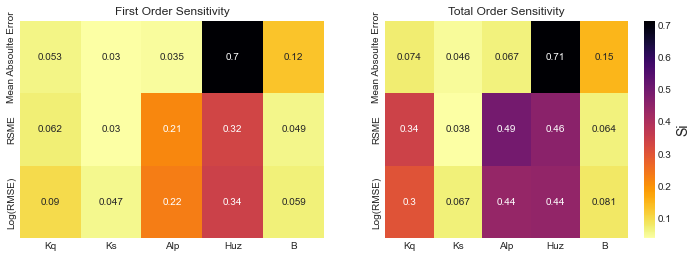

In [57]:
# create seaborn heatmap with required labels
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
# labels for y-axis
y_axis_labels = ['Mean Absoulte Error', 'RSME', 'Log(RMSE)']

# plot heatmap
ax1 = sns.heatmap(df_metric_s1_result, yticklabels=y_axis_labels, annot=True,  cmap='inferno_r', cbar_kws={'label': 'Si'}, cbar=False)
ax1.figure.axes[-1].yaxis.label.set_size(14)
ax1.set_title('First Order Sensitivity')
                 
ax2 = fig.add_subplot(122)
ax2 = sns.heatmap(df_metric_sT_result, yticklabels=y_axis_labels, annot=True,  cmap='inferno_r', cbar_kws={'label': 'Si'})
ax2.figure.axes[-1].yaxis.label.set_size(14)
ax2.set_title('Total Order Sensitivity')
                 

The first order sensitivity indicies indicate that HYMOD's sensitivity to its parameters is different depending on how its output is measured. Unsurprisingly, the mean absolute error is highly sensitive to the soil moisture accounting parameters Huz and B, just like the overall streamflow predictions above. However, when we examine RMSE and log(RMSE), the routing parameters Alp become sensitive, and the sensitivity to parameter B is reduced. As described above, RMSE and LOG(RMSE) respond to model performance in high-flow and low flow periods respectively. Our results indicate that for these flow regimes Alp, the parameter that governs the split between quick and slow flow is an important factor. While still the parameter with the highest most effect on all three measures, Huz is much less influential for RMSE and LOG(RMSE) than it is for MAE.

The total order sensitivity indicies review a different, more complex story. While the MAE sensitivity is relatively governed by first order effects (like the streamflow predictions above), the RMSE and LOG(RMSE) error metrics show significant interactions. Alp has the highest total order sensitivity for RMSE and is eqal to Huz for Log(RMSE). Kq, which has a relatively low first order sensitivity index, shows strong contribution to variance when interactions are taken into account.

Radial convergence plots are a helpful way to visualize the interactions between parameters. These plots array the model parameters in a circle and plot the first order, total order and second order Sobol sensitivity indices for each parameter. The first order sensitivity is shown as the size of a closed circle, the total order as the size of a larger open circle and the second order as the thickness of a line connecting two parameters. Below is an example of a radial convergence plot for the LOG(RMSE) measure. The plot indicates strong interactions between the Huz and Alp parameters, as well as Alp and Kq. There is also an interaction between Alp and Ks.  

Soil Moisture
Routing


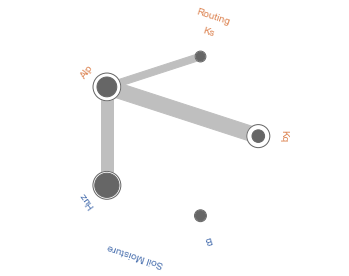

In [55]:
import numpy as np
import itertools
import seaborn as sns
import math

sns.set_style('whitegrid', {'axes_linewidth': 0, 'axes.edgecolor': 'white'})
 
    
def is_significant(value, confidence_interval, threshold="conf"):
    if threshold == "conf":
        return value - abs(confidence_interval) > 0
    else:
        return value - abs(float(threshold)) > 0


def grouped_radial(SAresults, parameters, radSc=2.0, scaling=1, widthSc=0.5, STthick=1, varNameMult=1.3, colors=None, groups=None, gpNameMult=1.5, threshold="conf"):
    # Derived from https://github.com/calvinwhealton/SensitivityAnalysisPlots
    fig, ax = plt.subplots(1, 1)
    color_map = {}
     
    # initialize parameters and colors
    if groups is None:
         
        if colors is None:
            colors = ["k"]
         
        for i, parameter in enumerate(parameters):
            color_map[parameter] = colors[i % len(colors)]
    else:        
        if colors is None:
            colors = sns.color_palette("deep", max(3, len(groups)))
         
        for i, key in enumerate(groups.keys()):
            #parameters.extend(groups[key])
             
            for parameter in groups[key]:
                color_map[parameter] = colors[i % len(colors)]
     
    n = len(parameters)
    angles = radSc*math.pi*np.arange(0, n)/n
    x = radSc*np.cos(angles)
    y = radSc*np.sin(angles)
     
    # plot second-order indices
    for i, j in itertools.combinations(range(n), 2):
        #key1 = parameters[i]
        #key2 = parameters[j]
         
        if is_significant(SAresults["S2"][i][j], SAresults["S2_conf"][i][j], threshold):
            angle = math.atan((y[j]-y[i])/(x[j]-x[i]))
                 
            if y[j]-y[i] < 0:
                angle += math.pi
                 
            line_hw = scaling*(max(0, SAresults["S2"][i][j])**widthSc)/2
                 
            coords = np.empty((4, 2))
            coords[0, 0] = x[i] - line_hw*math.sin(angle)
            coords[1, 0] = x[i] + line_hw*math.sin(angle)
            coords[2, 0] = x[j] + line_hw*math.sin(angle)
            coords[3, 0] = x[j] - line_hw*math.sin(angle)
            coords[0, 1] = y[i] + line_hw*math.cos(angle)
            coords[1, 1] = y[i] - line_hw*math.cos(angle)
            coords[2, 1] = y[j] - line_hw*math.cos(angle)
            coords[3, 1] = y[j] + line_hw*math.cos(angle)
 
            ax.add_artist(plt.Polygon(coords, color="0.75"))
         
    # plot total order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["ST"][i], SAresults["ST_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, color='w'))
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, lw=STthick, color='0.4', fill=False))
     
    # plot first-order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["S1"][i], SAresults["S1_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["S1"][i]**widthSc)/2, color='0.4'))
            
    # add labels
    for i, key in enumerate(parameters):                
        ax.text(varNameMult*x[i], varNameMult*y[i], key, ha='center', va='center',
                rotation=angles[i]*360/(2*math.pi) - 90,
                color=color_map[key])
         
    if groups is not None:
        for i, group in enumerate(groups.keys()):
            print(group)
            group_angle = np.mean([angles[j] for j in range(n) if parameters[j] in groups[group]])
             
            ax.text(gpNameMult*radSc*math.cos(group_angle), gpNameMult*radSc*math.sin(group_angle), group, ha='center', va='center',
                rotation=group_angle*360/(2*math.pi) - 90,
                color=colors[i % len(colors)])
             
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('equal')
    plt.axis([-2*radSc, 2*radSc, -2*radSc, 2*radSc])
    #plt.show()
 
     
    return fig

# define groups for parameter uncertainties
groups={"Soil Moisture" : ["Huz", "B"],
        "Routing" : ["Alp", "Kq", "Ks"]}
 
 
fig = grouped_radial(Si, ['Kq', 'Ks', 'Alp', 'Huz', 'B'], groups=groups, threshold=0.025)

<a id='TVSA'></a> 
## 2.4 Time-Varying Sensitivity Analysis

In section 2.5 we saw how performing sensitivity analysis on different measurements of model output can yeild in different results on the importance of each uncertain input. In this section we'll examine how performing this analysis over time can yeild additional insight into the performance of HYMOD. We'll first examine how model sensitivities vary by month, then examine how they change across each year of the simulation.

For this demonstration, we'll focus only on the monthly streamflow predictions generated by HYMOD.

### 2.4.1 Sensitivity analysis indices for each month


In [37]:
# aggregate simulated streamflow data to monthly time series
df_sim_by_mth_mean = Q_df.groupby('month')[sample_column_names].mean()

# aggregate observed streamflow data to monthly time series
df_obs_by_mth_mean = leaf_data.groupby('month').mean()


We can use the following to calculate the SA indices for each month and visualize it. Results are pre-loaded for efficiency.
```python
# set up dataframes to store outputs
df_mth_s1 = pd.DataFrame(np.zeros((12,5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
df_mth_delta = df_mth_s1.copy()

# iterate through each month
for i in range(0, 12):
    
    # generate the simulation data
    Y = df_sim_by_mth_mean.iloc[i, :].to_numpy()
    
    # run SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add to output dataframes
    df_mth_s1.iloc[i, :] = np.maximum(Si['S1'], 0)
    df_mth_delta.iloc[i, :] = np.maximum(Si['delta'], 0)  
    
# convert to arrays
arr_mth_s1 = df_mth_s1.values
arr_mth_delta = df_mth_delta.values
```   

#### First-order Indices
The following can be used to visualize the time-varying first-order indices. The first order represents the direct impacts of a specific parameter on model outputs.

<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/docs/html/A3_plotting_code.html#plot-monthly-heatmap">plot_monthly_heatmap</a>

</div>

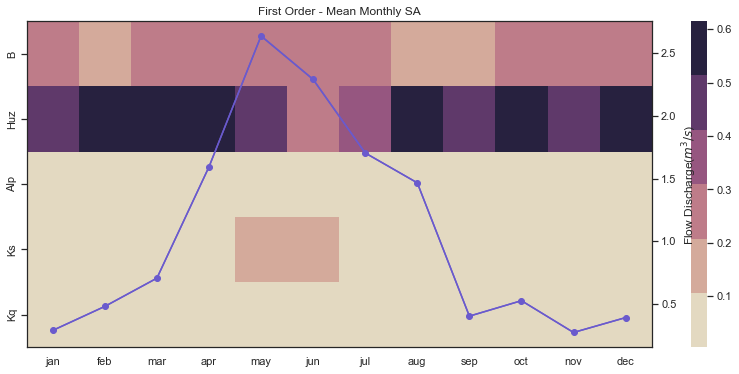

In [38]:
# load previously ran data
arr_mth_delta, arr_mth_s1 = msdbook.load_hymod_monthly_simulations()

# plot figure
ax, ax2 = msdbook.plot_monthly_heatmap(arr_sim=arr_mth_s1.T,
                                       df_obs=df_obs_by_mth_mean,
                                       title='First Order - Mean Monthly SA')


This figure demonstrates the first order sensitivity indices when the streamflow data are aggregated by month. The purple line represents the observed monthly discharge. The figure indicates that the first order indices are highest for B and Huz across all months and lowest for Alp, Ks, and Kq. Note that in the months with the highest flow, Ks becomes an influential parameter.

#### Total-order indices
We can also focus on the total order sensitivity index that includes first-order SA indices and interactions between parameters

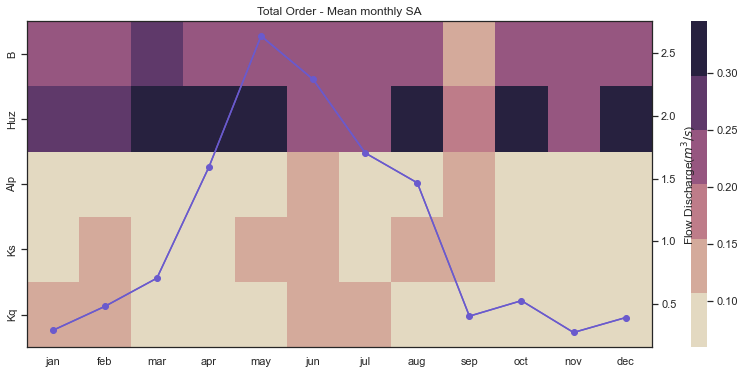

In [39]:
# plot figure
ax, ax2 = msdbook.plot_monthly_heatmap(arr_sim=arr_mth_delta.T,
                                       df_obs=df_obs_by_mth_mean,
                                       title='Total Order - Mean monthly SA')


Notably, the total order sensitivity results are different than the first order sensitivity results, which indicates that interactions between the parameters (particularly in regards to routing parameters $Kq$, $Ks$, and $Alp$) contribute to changes in HYMOD output. 

### 2.4.2 Annual sensitivity analysis indices

In [44]:
# group by year and get mean
df_sim_by_yr_mean = Q_df.groupby(['year'])[sample_column_names].mean()

# group input data and get mean
df_obs_by_yr_mean = leaf_data.groupby(['year']).mean()


We can also calculate the sensitivity analysis indices for each individual year. This will allow us to understand if model control changes during different years. The following code first aggregates the outputs to annual time steps, and then calculates the SA indices.
```python
# set up dataframes to store outputs
df_yr_s1 = pd.DataFrame(np.zeros((10, 5)), columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])
df_yr_delta = df_yr_s1.copy()

# iterate through each year
for i in range(0, 10):
    
    # generate the simulation data
    Y = df_sim_by_yr_mean.iloc[i, :].to_numpy()
    
    # run SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add to output dataframes
    df_yr_s1.iloc[i, :] = np.maximum(Si['S1'], 0)
    df_yr_delta.iloc[i, :] = np.maximum(Si['delta'], 0)  
    
# convert to arrays
arr_yr_s1 = df_mth_s1.values
arr_yr_delta = df_mth_delta.values
```

#### First-order indices

<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/docs/html/A3_plotting_code.html#plot-annual-heatmap">plot_annual_heatmap</a>

</div>

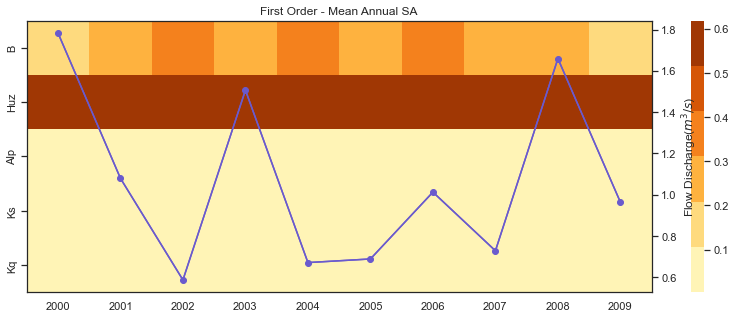

In [45]:
# load previously ran data
arr_yr_delta, arr_yr_s1 = msdbook.load_hymod_annual_simulations()

# plot figure
ax, ax2 = msdbook.plot_annual_heatmap(arr_sim=arr_yr_s1.T, 
                                      df_obs=df_obs_by_yr_mean,
                                      title='First Order - Mean Annual SA')


The first order sensitivities at the annual scale are not unlike the first order monthly sensitivities. Once again, sensitivities vary across year and Huz and B are the most consequential parameters. 

#### Total-order indices

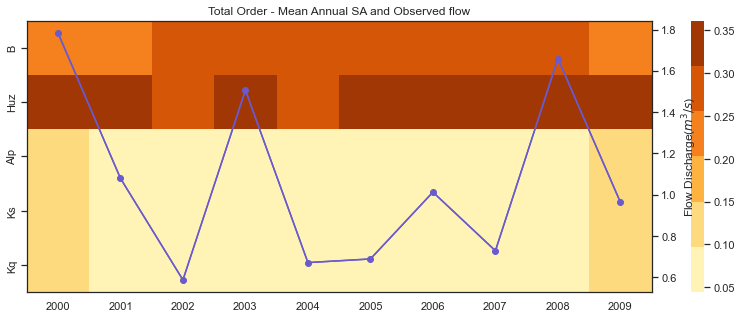

In [46]:
# plot figure
ax, ax2 = msdbook.plot_annual_heatmap(arr_sim=arr_yr_delta.T, 
                                      df_obs=df_obs_by_yr_mean,
                                      title='Total Order - Mean Annual SA and Observed flow')


Our results indicate that sensitivity analysis indices vary in different years and now that interactions are included, the Kq, Ks, and Alp variables impact the sensitivity of the streamflow output. 

### 2.4.3 Monthly time-varying sensitivity analysis

Although time-varying sensitivity analysis (TVSA) at average monthly and average annual temporal resolutions is informative, TVSA is susceptible to the aggregation issue that we discussed earlier in section 3-2. To avoid that we can further discretize our time domain to zoom into individual months. This will provide us with even more information about model behavior and the sensitivity of different parameters in different states of the system. The block of code demonstrates how to implement the monthly TVSA.
```python
# set up dataframes to store outputs
df_vary_s1 = pd.DataFrame(np.zeros((df_obs_mth_mean.shape[0], 5)), 
                          columns=['Kq', 'Ks', 'Alp', 'Huz', 'B'])

df_vary_delta = df_vary_s1.copy()

# iterate through each month
for i in range(0, df_obs_mth_mean.shape[0]):
    
    # generate the simulation data
    Y = df_sim_mth_mean.iloc[i, :].to_numpy()
    
    # run SA
    Si = delta.analyze(problem_hymod, param_values_hymod, Y, print_to_console=False)
    
    # add to output dataframes
    df_vary_s1.iloc[i, :] = np.maximum(Si['S1'], 0)
    df_vary_delta.iloc[i, :] = np.maximum(Si['delta'], 0)  
    
# convert to arrays
arr_vary_s1 = df_vary_s1.values
arr_vary_delta = df_vary_delta.values
```

#### First-order indices

<div class="alert alert-block alert-info">
    <b>Tip:</b> View the source code used to create this plot here:  <a href="https://immm-sfa.github.io/msd_uncertainty_ebook/docs/html/A3_plotting_code.html#plot-varying-heatmap">plot_varying_heatmap</a>

</div>

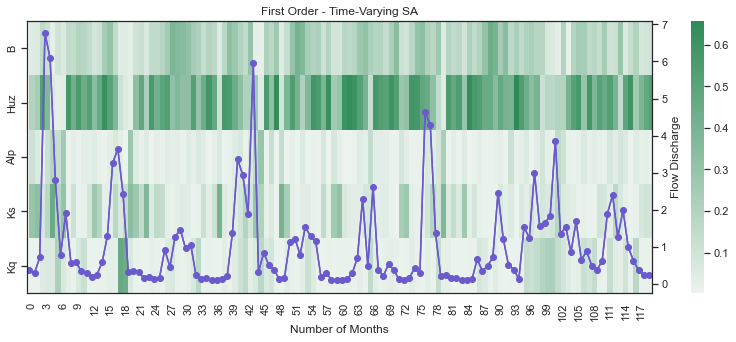

In [47]:
# load in previously ran data
arr_vary_delta, arr_vary_s1 = msdbook.load_hymod_varying_simulations()

# plot figure
ax, ax2 = msdbook.plot_varying_heatmap(arr_sim=arr_vary_s1.T, 
                                      df_obs=df_obs_mth_mean,
                                      title='First Order - Time-Varying SA')


Compared to the TVSA when streamflow was aggregated, this figure suggests that Kq is indeed a relevant parameter for influencing streamflow output when individual months are considered.   

#### Total order - time varying sensitivity analysis

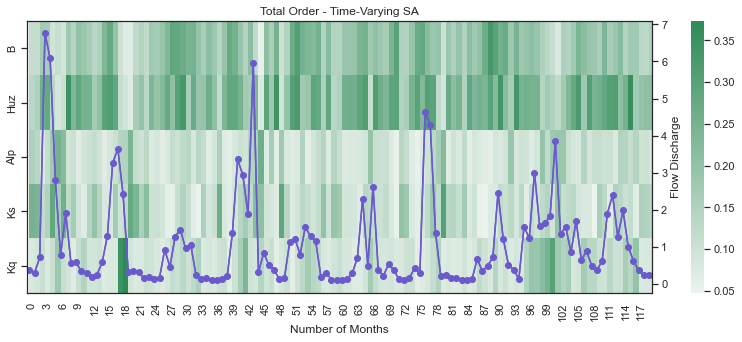

In [48]:
# plot figure
ax, ax2 = msdbook.plot_varying_heatmap(arr_sim=arr_vary_delta.T, 
                                      df_obs=df_obs_mth_mean,
                                      title='Total Order - Time-Varying SA')


As above, the total order sensitivities further indicate the importance of Kq that is not apparent if aggregation is utilized. 

# Tips to Apply this methodology to your own problem

In this tutorial, we demonstrated how to use global sensitivtiy analysis to explore a complex, non-linear model. We showed how measuring sensitivity across multiple measures of model performance and temporal aggregations yeilding differing results about model sensitivity/behavoir. While these results may seem contraditory, they provide useful insight into the behavoir of HYMOD. Would we  expect the same parameters to control high flow and low flow regimes within the model? Maybe, depending on the system, but also, maybe not. This analysis can provide insight into how the model responds to its input parameters, allowing us to compare the results to our expectaions. This may allow us to find problems with our intial assumptions, or call attention to model features that can be improved or expanded upon. Depending on the model and context, it may also yield insight into the workings of the underlying system.

To run this tutorial on your own model you will need to:

1. Design your experiment by choosing sampling bounds for your parameters and setting up the problem dictionary as in step 2-2
2. Choose the parameters of interest
2. Generate samples using the saltelli.sample function. This step is problem-dependent and note that the Sobol method can be computationally intensive depending on the model being analyzed. More complex models will be slower to run and will also require more samples to calculate accurate estimates of Sobol indices. Once you complete this process, pay attention to the confidence bounds on your sensitivity indices to see whether you need to run more samples.
4. Run the parameter sets through your model and record each of the desired model outputs.
5. Calculate the Sobol indices for each performance criteria. Now, the Y will be a numpy array with your external model output and you will need to include the parameter samples as an additional argument.
6. Follow the procedure in step 2.6 to disaggregate performance across time